# Gaussian Process on the Toy dataset, using Inducing Points

# Github

In [1]:
from google.colab import drive # For github
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Project18/GPs
!git config --global user.email "alexander.sabelstrom.1040@student.uu.se"
!git config --global user.name "Sabelz"

Mounted at /content/drive
/content/drive/MyDrive/Project18/GPs


# Imports

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Project18/datasets


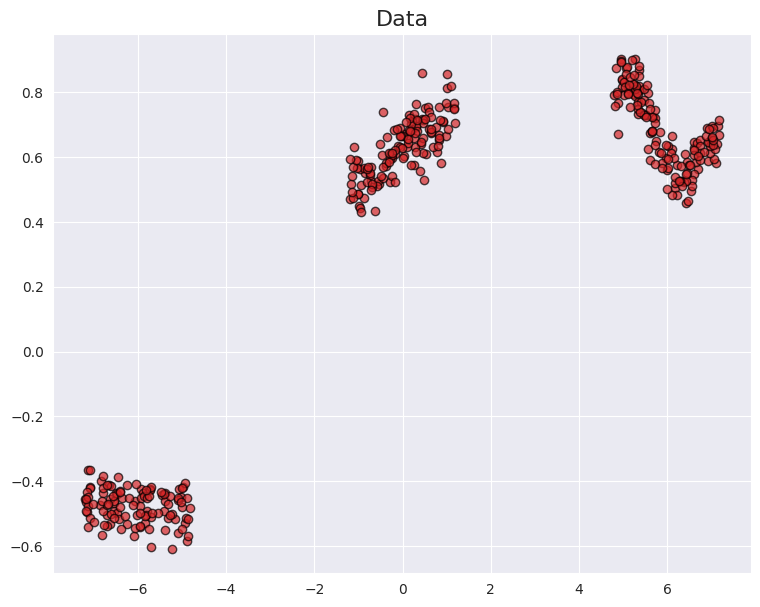

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install gpytorch
import gpytorch
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import time
import math
%matplotlib inline
%load_ext autoreload
%autoreload 2
%run ../datasets/toy.ipynb # Run the toy notebook which is in the datasets folder(toy dataset)


# Training data from toy.ipynb

In [81]:
xTrain, yTrain = x, y # x, y are defined in ../datasets/toy.ipynb
xTrain, yTrain = torch.from_numpy(xTrain), torch.from_numpy(yTrain) # Convert them to tensors
print(len(xTrain))

400


# Inducing Points

In [102]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
amount_of_points = 320 # 80%
inducingPointsX = xTrain[:amount_of_points] # Choose how many points to pick
inducingPointsY = yTrain[:amount_of_points] # Choose how many points to pick

# Test points
inducingPointsX_test = xTrain[amount_of_points:]
inducingPointsY_test = yTrain[amount_of_points:]
print(len(inducingPointsX), len(inducingPointsX_test))

320 80


# The GP model

In [103]:
# Class for the GP model(Exact GP)
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, x_Inducing, y_Inducing, likelihood):
        super(GPModel, self).__init__(x_Inducing, y_Inducing, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() # Decide which mean to use
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # Decide which kernel to use
    # GP Posterior predictive distribution
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize the first model

In [104]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

# Training Function

In [105]:
import os
def train(model, xTrain, yTrain): # Train the model on training data: xTrain, yTrain

  smoke_test = ('CI' in os.environ)
  training_iter = 2 if smoke_test else 500


  # Find optimal model hyperparameters
  model.train()
  model.likelihood.train()

  # Use the adam optimizer
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

  # "Loss" for GPs - the marginal log likelihood
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
  # Train without printing to ensure the training method is as fast as possible
  for i in range(training_iter):
      # Zero gradients from previous iteration
      optimizer.zero_grad()
      # Output from model
      output = model(xTrain)
      # Calc loss and backprop gradients
      loss = -mll(output, yTrain)
      loss.backward()
      optimizer.step()


# Train the Model#

In [106]:
%time train(model, inducingPointsX, inducingPointsY)

CPU times: user 7.89 s, sys: 19.4 ms, total: 7.91 s
Wall time: 8.13 s


# Root Mean Square Error(RMSE)

In [107]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(inducingPointsX_test))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
    mean = observed_pred.mean.numpy()

squared_error = (mean - inducingPointsY_test.numpy())**2 # Compute the squared error

mean_SE = squared_error.mean() # Compute the mean squared error

root_MSE = np.sqrt(mean_SE) # Compute the square root of the mean squared error

root_MSE

0.054716742811986706

# Test data

In [108]:
# Observing the plot of the toy dataset, x varies between -7-7
xTest = torch.linspace(-10, 10, 50)

# The posterior mean, variance and Covariance Matrix

In [109]:
model.eval() # eval mode is for computing predictions through the model posterior
f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
f_mean = f_preds.mean # Predictive mean
f_var = f_preds.variance # Predictive variance
f_covar = f_preds.covariance_matrix # Covariance matrix
print("Mean Dimension: ", f_mean.size())
print()
print("Variance Dimension: ", f_var.size())
print()
print("CovMatrix Dimension ", f_covar.size())

Mean Dimension:  torch.Size([50])

Variance Dimension:  torch.Size([50])

CovMatrix Dimension  torch.Size([50, 50])


# Plots of samples from the GP

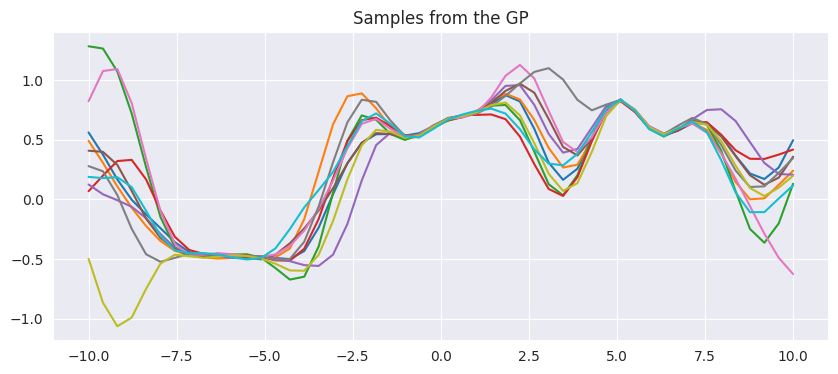

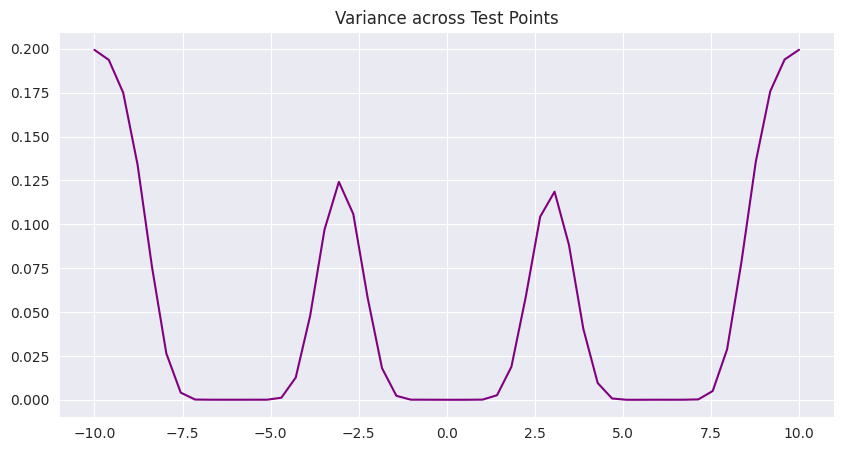

In [110]:
# Convert to numpy
xTestPlot = xTest.detach().numpy()
f_meanPlot = f_mean.detach().numpy()
f_varPlot = f_var.detach().numpy()
# Plot samples from the GP
plt.figure(figsize=(10, 4))
for i in range(10):  # Generate 20 samples
    f_sample = f_preds.sample().detach().numpy()
    plt.plot(xTestPlot, f_sample)
plt.title('Samples from the GP')
plt.show()
# Plot variance
plt.figure(figsize=(10, 5))
plt.plot(xTestPlot, f_varPlot, 'purple')
plt.title('Variance across Test Points')
plt.show()

# Predictive Distribution

In [111]:
model.eval() # eval mode is for computing predictions through the model posterior.
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
    observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

# Plot with RBF kernel

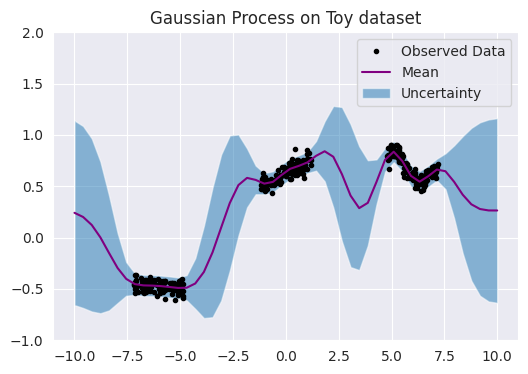

In [112]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
    # Plot predictive means as purple line
    ax.plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-1, 2])
    ax.set_title("Gaussian Process on Toy dataset")
    ax.legend(['Observed Data', 'Mean', 'Uncertainty'])

# Compare different amount of points


Inducing Points:  5
CPU times: user 1.39 s, sys: 14.6 ms, total: 1.4 s
Wall time: 1.41 s

Inducing Points:  10


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1.39 s, sys: 11.4 ms, total: 1.4 s
Wall time: 1.41 s

Inducing Points:  50
CPU times: user 1.54 s, sys: 13.5 ms, total: 1.55 s
Wall time: 1.56 s

Inducing Points:  100
CPU times: user 1.81 s, sys: 10.2 ms, total: 1.82 s
Wall time: 1.82 s

Inducing Points:  200
CPU times: user 4.59 s, sys: 17.7 ms, total: 4.61 s
Wall time: 6.14 s

Inducing Points:  400
CPU times: user 11 s, sys: 233 ms, total: 11.2 s
Wall time: 11.3 s


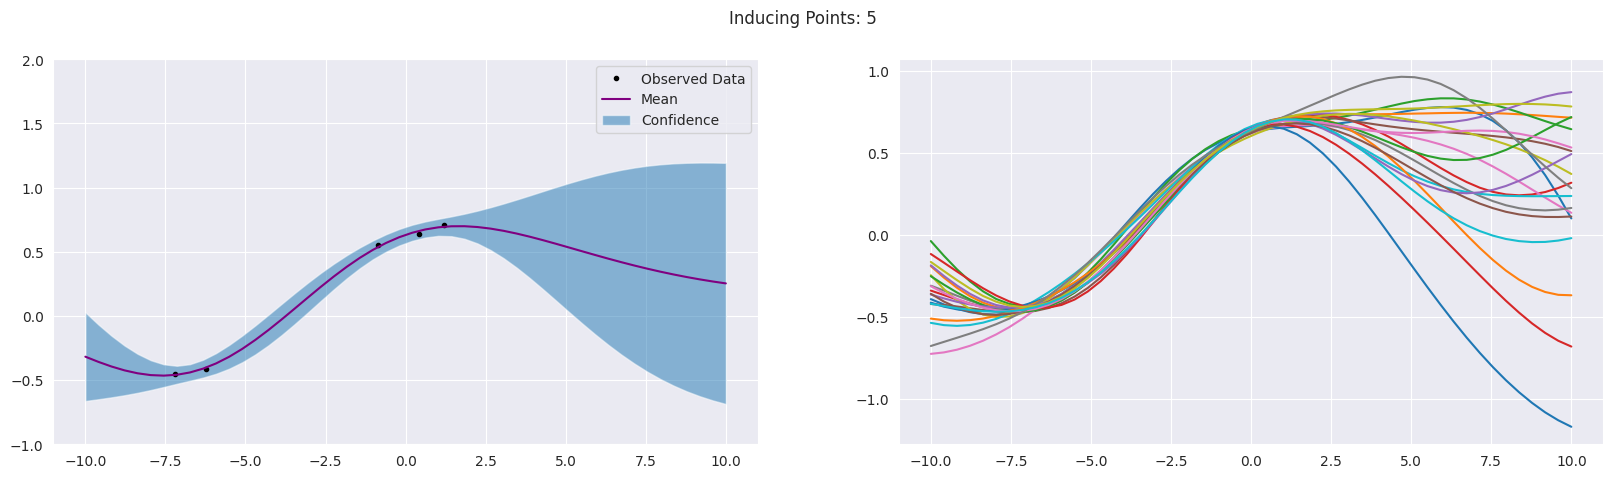

<Figure size 1000x400 with 0 Axes>

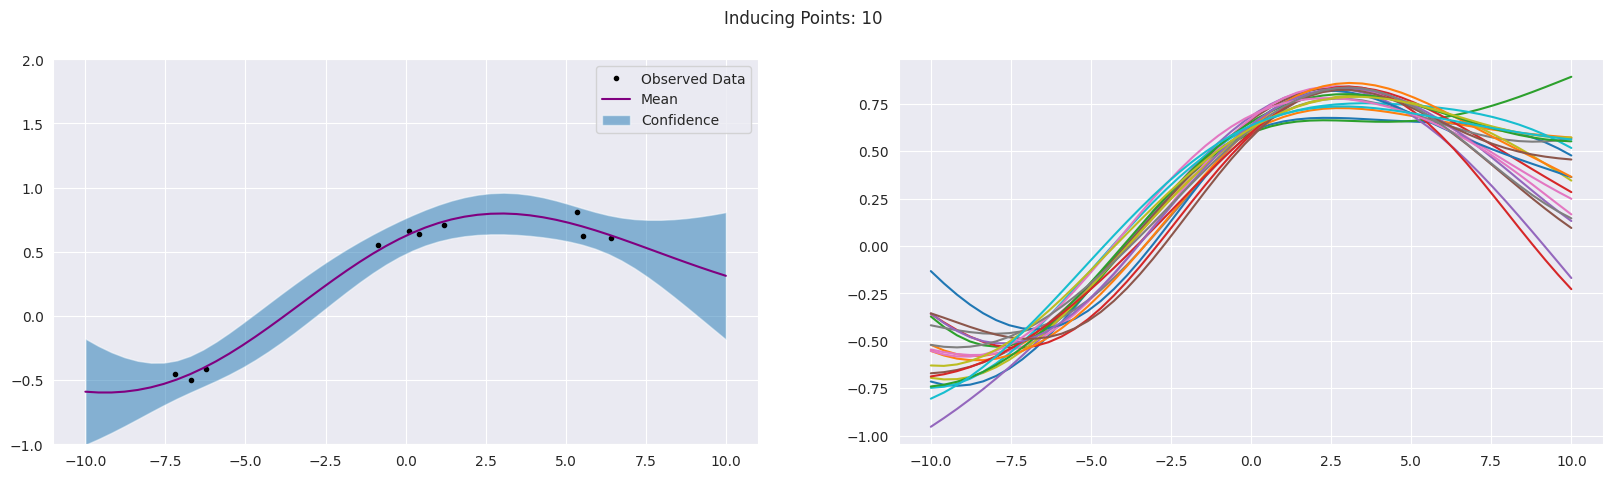

<Figure size 1000x400 with 0 Axes>

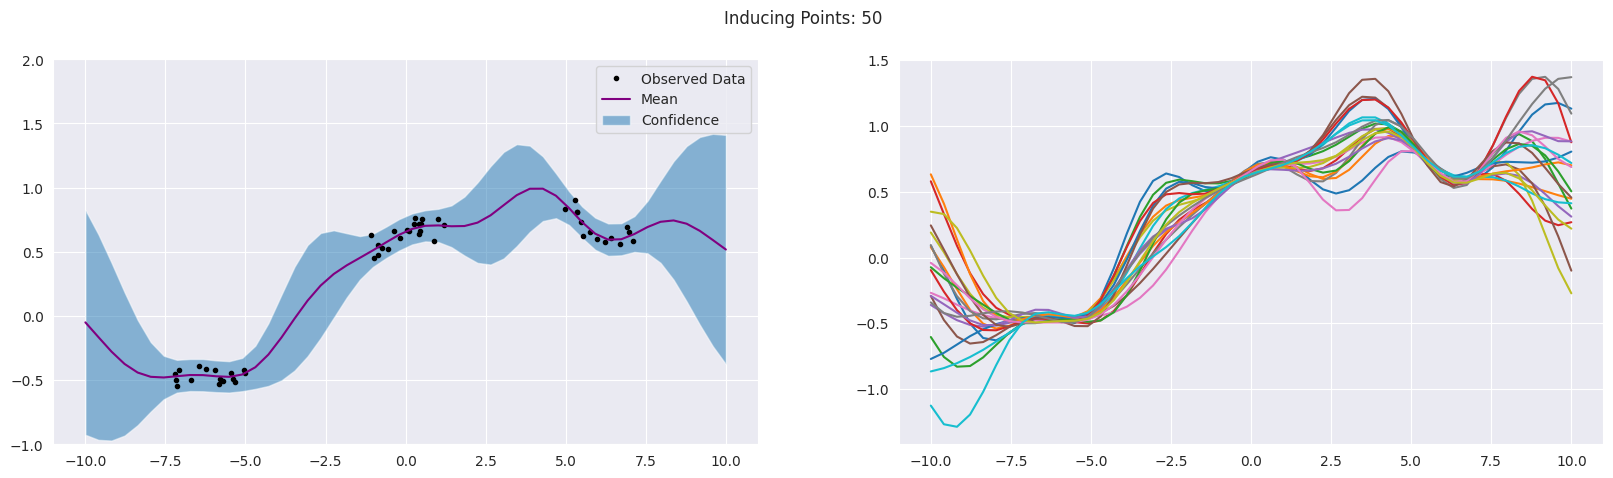

<Figure size 1000x400 with 0 Axes>

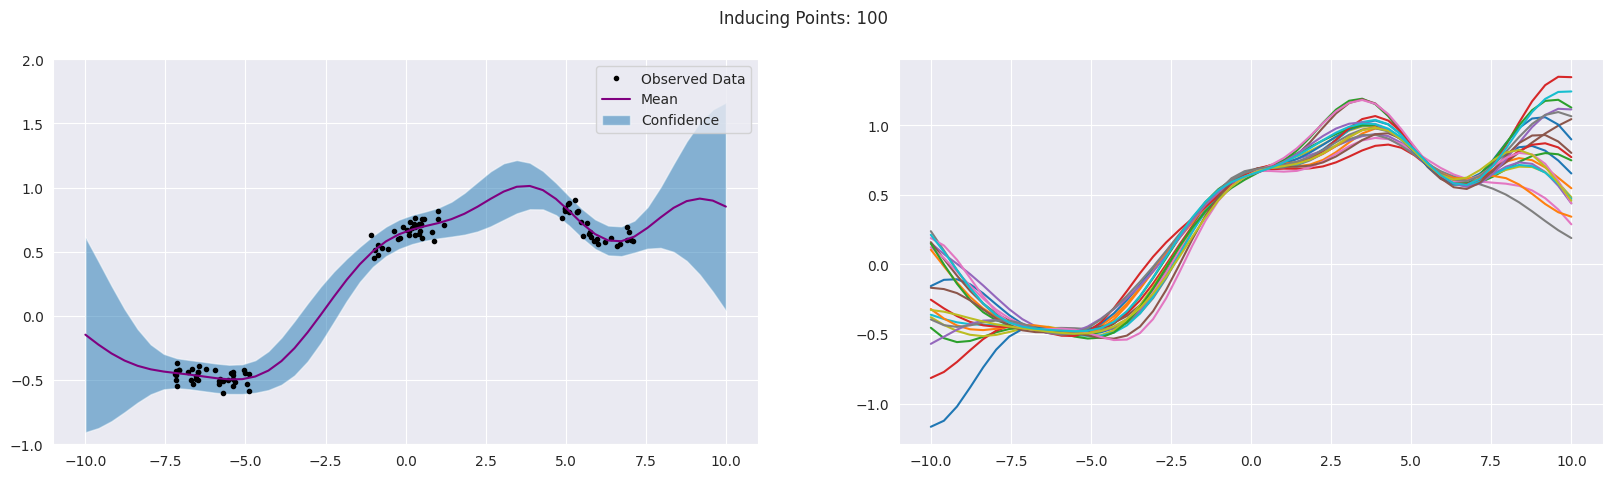

<Figure size 1000x400 with 0 Axes>

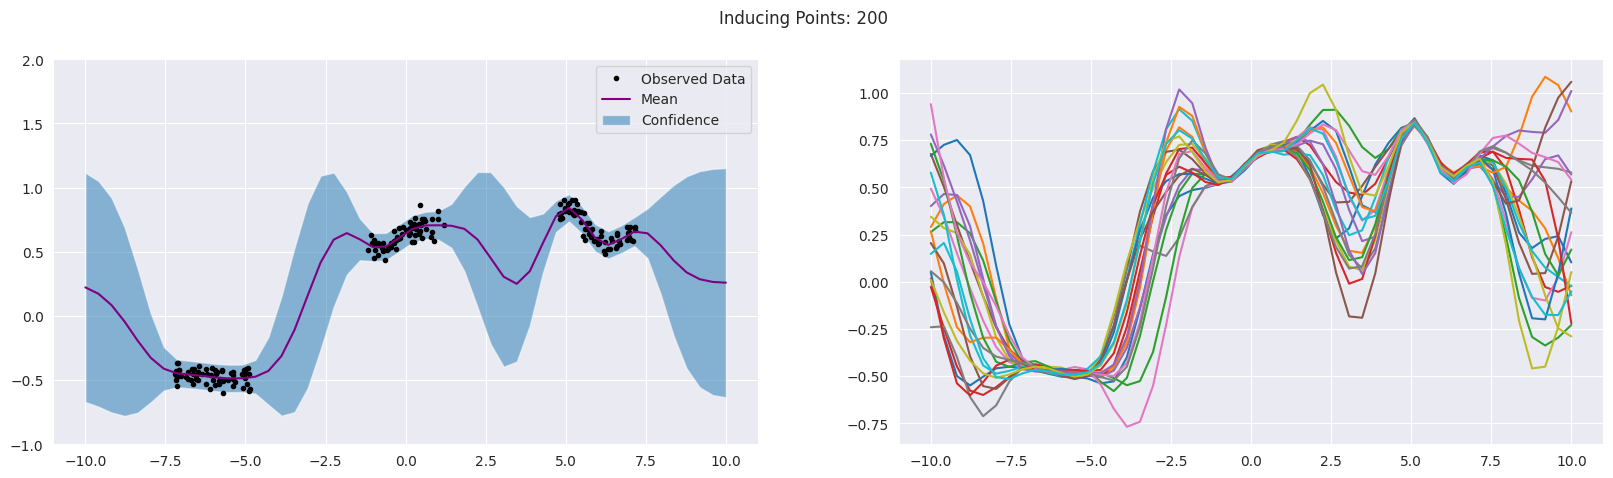

<Figure size 1000x400 with 0 Axes>

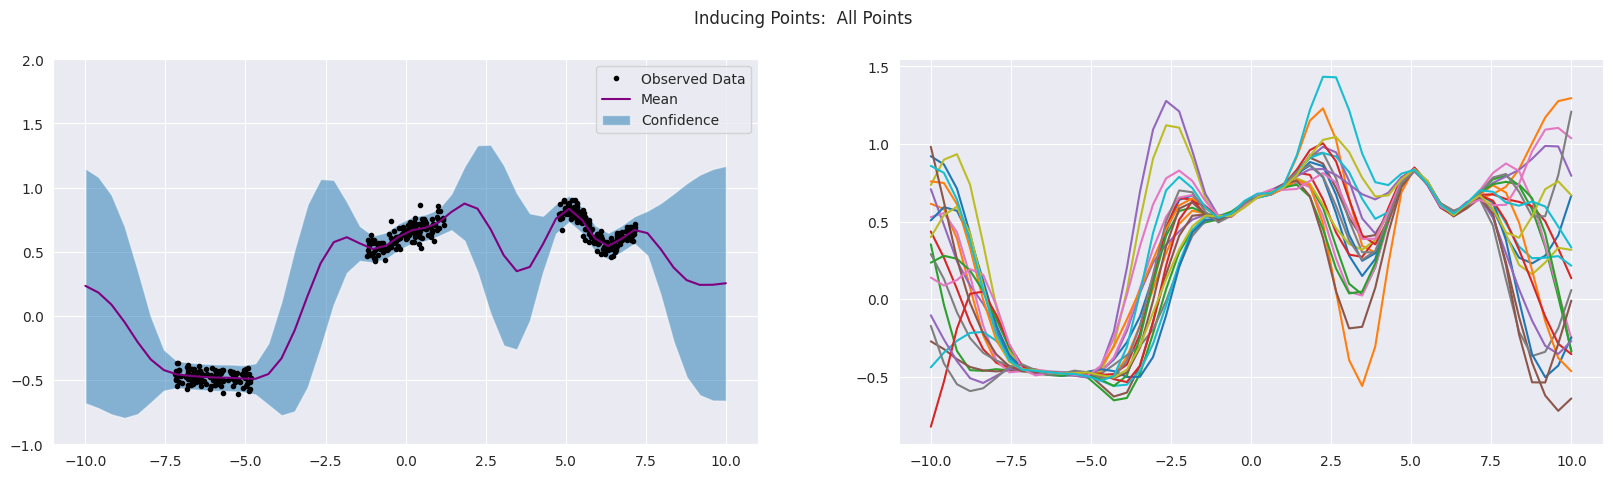

<Figure size 1000x400 with 0 Axes>

In [113]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPoints(listOfPoints):
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    inducingPointsX = xTrain[:points] # Choose how many points to pick
    inducingPointsY = yTrain[:points] # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    print()
    print("Inducing Points: ", points)

    %time train(model, inducingPointsX, inducingPointsY) # Train the model
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()



    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
        observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

        f, ax = plt.subplots(1, 2, figsize=(20, 5))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black dots
        ax[0].plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
        # Plot predictive means as purple line
        ax[0].plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax[0].set_ylim([-1, 2])
        ax[0].legend(['Observed Data', 'Mean', 'Confidence'])

        f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
        f_mean = f_preds.mean # Predictive mean
        f_var = f_preds.variance # Predictive variance
        xTestPlot = xTest.detach().numpy()
        f_meanPlot = f_mean.detach().numpy()
        f_varPlot = f_var.detach().numpy()
        # Plot samples from the GP
        plt.figure(figsize=(10, 4))
        for i in range(20):  # Generate 20 samples
            f_sample = f_preds.sample().detach().numpy()
            ax[1].plot(xTestPlot, f_sample)
        if(points == maxPoints):
           f.suptitle('Inducing Points:  All Points')  # If all training points are used
        else:
          f.suptitle('Inducing Points: '+ str(points)) # Else print current amount of points

severalInducingPoints([5,10,50,100,200,400])


# Use K-means clustering to choose inducing points

# function for calculating inducing points

In [114]:
def kmeansPoints(x, y, N): # The dataset (X,Y) and the N amount of inducing points wished
  # Normalize training points
  x_mean = x.mean(axis = 0) # mean for each feature
  x_std = x.std(axis = 0) # std for each feature
  x_normalized = (x-x_mean) / x_std # Normalize
  RS = 0 # Random state
  xTrain_KMeans = x_normalized.reshape(-1,1)
  kmeans = KMeans(n_clusters=N, n_init=1, random_state=RS ).fit(xTrain_KMeans) # Apply K-means clustering on the normalized training data
  xInducing = kmeans.cluster_centers_ # Use the centers of the clusters as the inducing points
  # To get the corresponding y values for each inducing point, compute the closest data point.
  closest_indices, _ = pairwise_distances_argmin_min(xInducing, xTrain_KMeans) # Will return indexes of xTrain_KMeans which is most similar(the same in this case) as xInducing
  yInducing = y[closest_indices] # Choose the corresponding y values for the inducing points
  xInducing = x[closest_indices] # We want to return the non-normalized x
  return xInducing, yInducing

# Compare different amount of inducing points

In [ ]:
# Trains models one by one for each amount of inducing points, and plots each model with plots [rows,columns](must match the length of listOfPoints)
def severalInducingPointsKmeans(listOfPoints):
  maxPoints = len(xTrain) # The max amount of points in training points
  for points in listOfPoints:
    print()
    print("Inducing Points: ", points)
    inducingPointsX, inducingPointsY = %time kmeansPoints(xTrain, yTrain, points) # Choose how many points to pick

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()


    %time train(model, inducingPointsX, inducingPointsY) # Train the model
    # Plot
    model.eval() # eval mode is for computing predictions through the model posterior.
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
        observed_pred = likelihood(model(xTest))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value

        f, ax = plt.subplots(1, 2, figsize=(20, 5))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black dots
        ax[0].plot(inducingPointsX.numpy(), inducingPointsY.numpy(), 'k.')
        # Plot predictive means as purple line
        ax[0].plot(xTest.numpy(), observed_pred.mean.numpy(), 'purple')
        # Shade between the lower and upper confidence bounds
        ax[0].fill_between(xTest.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax[0].set_ylim([-1, 2])
        ax[0].legend(['Observed Data', 'Mean', 'Confidence'])

        f_preds = model(xTest) # returns the model posterior distribution p(f* | x*, X, y), for training data X, y
        f_mean = f_preds.mean # Predictive mean
        f_var = f_preds.variance # Predictive variance
        xTestPlot = xTest.detach().numpy()
        f_meanPlot = f_mean.detach().numpy()
        f_varPlot = f_var.detach().numpy()
        # Plot samples from the GP
        plt.figure(figsize=(10, 4))
        for i in range(20):  # Generate 20 samples
            f_sample = f_preds.sample().detach().numpy()
            ax[1].plot(xTestPlot, f_sample)
        if(points == maxPoints):
           f.suptitle('Inducing Points:  All Points')  # If all training points are used
        else:
          f.suptitle('Inducing Points: '+ str(points)) # Else print current amount of points

severalInducingPointsKmeans([4,6,8,10,12,100])


Inducing Points:  4
CPU times: user 5.93 ms, sys: 0 ns, total: 5.93 ms
Wall time: 5.85 ms
CPU times: user 1.72 s, sys: 12 ms, total: 1.73 s
Wall time: 1.76 s

Inducing Points:  6
CPU times: user 4.54 ms, sys: 0 ns, total: 4.54 ms
Wall time: 4.52 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1.48 s, sys: 11.8 ms, total: 1.49 s
Wall time: 1.5 s

Inducing Points:  8
CPU times: user 4.33 ms, sys: 16 µs, total: 4.35 ms
Wall time: 4.41 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1.49 s, sys: 11.5 ms, total: 1.5 s
Wall time: 1.51 s

Inducing Points:  10
CPU times: user 4.68 ms, sys: 34 µs, total: 4.71 ms
Wall time: 4.77 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1.41 s, sys: 5.72 ms, total: 1.41 s
Wall time: 1.42 s

Inducing Points:  12
CPU times: user 5.11 ms, sys: 3 µs, total: 5.11 ms
Wall time: 5.21 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


CPU times: user 1.7 s, sys: 8.48 ms, total: 1.7 s
Wall time: 1.73 s

Inducing Points:  100
CPU times: user 29.8 ms, sys: 0 ns, total: 29.8 ms
Wall time: 29.8 ms


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


# Comparison of All training points and half Inducing Points

In [ ]:
import torch
from scipy.stats import norm

def compute_z_score(pred_interval: float) -> float:
    """
    Compute the z-score based on a given prediction interval.

    Parameters:
    - pred_interval (float): Prediction interval in the range (0, 100).

    Returns:
    float: The z-score corresponding to the given prediction interval.
    """
    # Convert pred_interval to a probability
    probability = pred_interval / 100

    # Compute z-score based on the probability
    z = norm.ppf((1 + probability) / 2)

    return z

def calculate_PIC_PIW(PIC:float, PIW:float, n:int, means:torch.Tensor, variances: torch.Tensor, y_true: torch.Tensor, pred_interval: float=95.0):
    """"
    Calculate Prediction Interval Coverage (PIC) and Prediction Interval Width (PIW) for a batch of predictions.

    Parameters:
    - PIC (float): Current Prediction Interval Coverage.
    - PIW (float): Current Prediction Interval Width.
    - n (int): Current total number of data points.
    - means (torch.Tensor): Tensor containing mean predictions.
    - variances (torch.Tensor): Tensor containing variances of predictions.
    - y_true (torch.Tensor): Tensor containing true values.
    - pred_interval (float, optional): Desired prediction interval (default is 95.0).

    Returns:
    Tuple of three values (PIC, PIW, n) representing the updated values after processing the current batch.

    This function calculates the Prediction Interval Coverage (PIC) and Prediction Interval Width (PIW) for a batch
    of predictions.

    The Prediction Interval (PI) is calculated as [mean - z * sqrt(variance), mean + z * sqrt(variance)], where z is
    determined based on the desired prediction interval.

    The function updates the input PIC, PIW, and n based on the performance of the model on the current batch.
    """
    z = compute_z_score(pred_interval)
    sigma = torch.sqrt(variances)
    # Update n by the batch size
    n += means.shape[0]
    # Calculate y_pred lower bound
    y_pred_L = means-(sigma*z)
    # Calculate y_pred upper bound
    y_pred_U = means+(sigma*z)
    # Check if  the true values are within the prediction interval
    above_lower_bound = y_pred_L < y_true
    below_upper_bound = y_pred_U > y_true
    # Calculate total number of data points captured for current batch and update
    # the Prediction Interval Coverage
    PIC += (above_lower_bound*below_upper_bound).sum().item()
    # Calculate the current batch's PI width and update the Prediction Interval Width (PIW)
    PIW += (y_pred_U-y_pred_L).sum().item()
    # Update PICP
    return PIC,PIW, n

    return calibration_error.item()

In [ ]:
def model_inducing_half(x_train, y_train, x_test, y_test):
    """
    Train a Gaussian Process (GP) model with half of the training points as Inducing Points and evaluate its performance on the test data.

    Parameters:
    - x_train (torch.Tensor): Input training data tensor of size (n_train x d), where n_train is the number of training samples and d is the number of features.
    - y_train (torch.Tensor): Output training data tensor of size (n_train), corresponding to the labels or values for each training sample.
    - x_test (torch.Tensor): Input test data tensor of size (n_test x d), where n_test is the number of test samples and d is the number of features.
    - y_test (torch.Tensor): Output test data tensor of size (n_test), corresponding to the labels or values for each test sample.

    Returns:
    - float: Total execution time (in seconds) for K-means clustering and training the GP model with Inducing Points.
    - float: Root Mean Squared Error (RMSE) on the test data.
    - float: Probability Calibration Index (PICP) on the test data.
    - float: Mean Prediction Interval Width (MPIW) on the test data.
    - GPModel: Trained GP model with Inducing Points.
    - float: Execution time (in seconds) for making predictions on the test data.
    """
    # Model with half training points being Inducing Points
    points = int(len(x_train)/2) # how many Inducing Points
    start_time = time.time() # Start time
    inducingPointsX, inducingPointsY = kmeansPoints(x_train, y_train, points) # Calculate Incucing Points
    end_time = time.time() # End time
    execution_time_kmeans = end_time - start_time # Calcualte execution time for K-means

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood
    model_inducing = GPModel(inducingPointsX, inducingPointsY, likelihood) # Send in inducing points as the training points
    model_inducing = model_inducing.to(device) # Move model to device
    start_time = time.time() # Start time
    train(model_inducing, inducingPointsX, inducingPointsY) # Train the model
    end_time = time.time() # End time
    execution_time_train_inducing = end_time - start_time # Calcualte execution time

    # Performance
    model_inducing.eval() # eval mode is for computing predictions through the model posterior.
    model_inducing.likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
      start_time = time.time() # Start time
      observed_pred_inducing =  model_inducing.likelihood(model_inducing(x_test))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
      end_time = time.time() # End time
      posterior_time_inducing = end_time - start_time # Calculate execution time

      prediction_means_inducing = observed_pred_inducing.mean # Mean
      prediction_variances_inducing = observed_pred_inducing.variance # Variance
      squared_error = (prediction_means_inducing - y_test)**2 # Compute the squared error
      mean_SE = squared_error.mean() # Compute the mean squared error
      RMSE_inducing = math.sqrt(mean_SE) # Compute the square root of the mean squared error

      # PCIP and MPIW
      pic,piw, n = calculate_PIC_PIW(0,0, 0, prediction_means_inducing, prediction_variances_inducing, y_test)
      picp_inducing = pic/n
      mpiw_inducing = piw/n

      training_time = execution_time_kmeans+execution_time_train_inducing # Total training time
      return training_time, RMSE_inducing, picp_inducing, mpiw_inducing, model_inducing, posterior_time_inducing

In [ ]:
training_time_inducing, RMSE_inducing, PICP_inducing, MPIW_inducing, model_inducing, posterior_time_inducing = model_inducing_half(inducingPointsX, inducingPointsY, inducingPointsX_test, inducingPointsY_test)

# All points

In [ ]:
def model_all_points(x_train, y_train, x_test, y_test):
    """
    Train a Gaussian Process (GP) model on the given training data and evaluate its performance on the test data.

    Parameters:
    - x_train (torch.Tensor): Input training data tensor of size (n_train x d), where n_train is the number of training samples and d is the number of features.
    - y_train (torch.Tensor): Output training data tensor of size (n_train), corresponding to the labels or values for each training sample.
    - x_test (torch.Tensor): Input test data tensor of size (n_test x d), where n_test is the number of test samples and d is the number of features.
    - y_test (torch.Tensor): Output test data tensor of size (n_test), corresponding to the labels or values for each test sample.

    Returns:
    - float: Execution time (in seconds) for training the GP model.
    - float: Root Mean Squared Error (RMSE) on the test data.
    - float: Probability Calibration Index (PICP) on the test data.
    - float: Mean Prediction Interval Width (MPIW) on the test data.
    - GPModel: Trained GP model.
    - float: Execution time (in seconds) for making predictions on the test data.
    """

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood() # Decide likelihood

    model = GPModel(x_train, y_train, likelihood)
    model = model.to(device) # Move model to device
    start_time = time.time() # Start time
    train(model, x_train, y_train) # Train the model
    end_time = time.time() # End time
    execution_time_train = end_time - start_time # Calcualte execution time
    # Performance
    model.eval() # eval mode is for computing predictions through the model posterior.
    model.likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var(): # https://arxiv.org/abs/1803.06058
      start_time = time.time() # Start time
      observed_pred =  model.likelihood(model(x_test))# gives us the posterior predictive distribution p(y* | x*, X, y) which is the probability distribution over the predicted output value
      end_time = time.time() # End time
      execution_time_posterior = end_time - start_time # Calculate execution time

      prediction_means = observed_pred.mean # Mean
      prediction_variances = observed_pred.variance # Variance

      squared_error = (prediction_means - y_test)**2 # Compute the squared error
      mean_SE = squared_error.mean() # Compute the mean squared error
      RMSE = math.sqrt(mean_SE) # Compute the square root of the mean squared error

      # PCIP and MPIW
      pic,piw, n = calculate_PIC_PIW(0,0, 0, prediction_means, prediction_variances, y_test)
      picp = pic/n
      mpiw = piw/n

      return execution_time_train, RMSE, picp, mpiw, model, execution_time_posterior

In [ ]:
training_time_final, RMSE_final, PICP_final, MPIW_final, model_final, posterior_time_final = model_all_points(inducingPointsX, inducingPointsY, inducingPointsX_test, inducingPointsY_test)

# Plot the difference

In [ ]:
times_compare = [training_time_inducing]+[training_time_final] # list of training times
RMSE_compare = [RMSE_inducing]+[RMSE_final] # List of RMSEs
PICPs_compare = [PICP_inducing]+[PICP_final] # List of PICPs
MPIWs_compare = [MPIW_inducing]+[MPIW_final] # List of MPIWs
# PLOT
width = 50
points_all = (len(inducingPointsX))
indices_final = [int(points_all/2), points_all] # x values in bar plot

fig, axs = plt.subplots(4, 1, figsize=(10, 8))  # Create a figure and a 1x2 subplot

# First subplot
axs[0].bar(indices_final, times_compare, label='Time', width = width, color = "purple")
axs[0].set_xlabel('Inducing Points and all training points')
axs[0].set_ylabel('Time')
axs[0].set_title('Total training time for different amount of Inducing Points for Toy Dataset')
axs[0].legend()

# Second subplot
axs[1].bar(indices_final, RMSE_compare, label='RMSE', width = width, color = "red")
axs[1].set_xlabel('Inducing Points and all training points')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE for different amount of Inducing Points for Toy Dataset')
axs[1].legend()



# Third subplot
axs[2].bar(indices_final, PICPs_compare, label='PICP', width = width, color = "green")
axs[2].set_xlabel('Inducing Points and all training points')
axs[2].set_ylabel('PICP')
axs[2].set_title('PICP for different amount of Inducing Points for Toy Dataset')
axs[2].legend()

# Fourth subplot
axs[3].bar(indices_final, MPIWs_compare, label='MPIW', width = width, color = "yellow")
axs[3].set_xlabel('Inducing Points and all training points')
axs[3].set_ylabel('MPIW')
axs[3].set_title('MPIW for different amount of Inducing Points for Toy Dataset')
axs[3].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()